In [1]:
import uproot as up
import awkward as ak
import coffea
from coffea.nanoevents.methods import candidate
from coffea import lookup_tools
from coffea.lookup_tools import extractor
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory, CorrectedMETFactory
from coffea.btag_tools.btagscalefactor import BTagScaleFactor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema, TreeMakerSchema
from coffea import processor

ak.behavior.update(candidate.behavior)
import numpy as np
import time
import cachetools
import pickle

In [6]:
# from dask.distributed import Client, progress

# client = Client(n_workers=2, threads_per_worker=1, memory_limit='1GB')
# client

In [4]:
from utils.run_helper import get_file_list
get_file_list("/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/VBFHToMuMu_M-125","*.parquet")

fdict = {
    'vbf': get_file_list("/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/VBFHToMuMu_M-125","*.parquet"),
}

In [5]:
fdict

{'vbf': ['/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/VBFHToMuMu_M-125/VBFHToMuMu_M-125_JcrS0wpbZnq.parquet',
  '/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/VBFHToMuMu_M-125/VBFHToMuMu_M-125_TYV0qW9dAsE.parquet',
  '/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/VBFHToMuMu_M-125/VBFHToMuMu_M-125_fdqiNlsPeu2.parquet',
  '/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/VBFHToMuMu_M-125/VBFHToMuMu_M-125_8mWXCtgi9M0.parquet',
  '/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/VBFHToMuMu_M-125/VBFHToMuMu_M-125_QEirzeq3DZU.parquet',
  '/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/VBFHToMuMu_M-125/VBFHToMuMu_M-125_H1o5MeBitny.parquet',
  '/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/VBFHToMuMu_M-125/VBFHToMuMu_M-125_lvfRzAig6Se.parquet',
  '/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/VBFHToMuMu_M-125/VBFHToMuMu_M-125_MeK1aE6Gs5b.parquet',
  '/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/VBFHToMuMu_M-125/VBFHToMuMu_M-125_mVCOlaGruN7.parquet',
  '/data/pub

In [7]:
# !ls /data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/DYJetsToLL_M-50/
events = NanoEventsFactory.from_parquet(
    '/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/WZTo3LNu_MG/new_0.parquet',
    schemaclass=NanoAODSchema,
).events()


In [10]:
events.Muon.pt

<Array [[114, 19.9], [64.1, ... [174, 100]] type='510596 * var * float32[paramet...'>

In [4]:
# events.HLT_IsoMu24.to_list()

In [37]:
eve = ak.from_parquet('/data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/VBFHToMuMu_M-125/VBFHToMuMu_M-125_BVAi06aP8hz.parquet')
eve.metFilter[:5].to_list()

[True, True, True, True, True]

In [8]:
run = processor.Runner(
    executor=processor.FuturesExecutor(workers=30),
    schema=NanoAODSchema,
    format="parquet",
    chunksize=100000,
)


In [9]:
from coffea import hist as chist
class vbf_sel(processor.ProcessorABC):
    """
    VBF selection after Object selection
    """

    def __init__(self, year='2018', data=False):
        self._accumulator = processor.dict_accumulator(
            {
                "ntot": processor.defaultdict_accumulator(int),
                "npos": processor.defaultdict_accumulator(int),
                "nneg": processor.defaultdict_accumulator(int),
                "neff": processor.defaultdict_accumulator(int),
                "npass": processor.defaultdict_accumulator(int),
                "zmass": chist.Hist(
                    "Events",
                    chist.Cat("dataset", "Dataset"),
                    chist.Bin("zmass", "$m_{\mu\mu}$ [GeV]", 30, 76, 106),                 
                ),                
                "hmass": chist.Hist(
                    "Events",
                    chist.Cat("dataset", "Dataset"),
                    chist.Bin("hmass", "$m_{\mu\mu}$ [GeV]", 40, 110, 150),                 
                ),                
                "mass": chist.Hist(
                    "Events",
                    chist.Cat("dataset", "Dataset"),
                    chist.Bin("mass", "$m_{\mu\mu}$ [GeV]", 80, 70, 150),                 
                ),                
            }
        )
        self.year = year
        self.data = data

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        result = self.accumulator.identity()
        dataset = events.metadata['dataset']

        if not self.data:
            # count nevents
            npos = ak.sum(events.Generator.weight > 0)
            nneg = ak.sum(events.Generator.weight < 0)
            ntot = len(events.Generator.weight)
        else:
            npos = len(events)
            nneg = 0
            ntot = len(events)            

        # print(events.fields)
        # print(type(events))
        ############
        # trigger
        events = events.mask[events.HLT.IsoMu24 > 0.5]
        ############
        # muons
        # logger.info(">>> Muon selection >>> entries %s",ak.sum((events.run!=None)))
        sel_nmu = ak.count(events.Muon.pt,axis=-1) == 2
        events = events.mask[sel_nmu]
        muons = events.Muon
        if not self.year == "2017":
            sel_mu_1 = (muons.pt[:,0] > 26) & (muons.pt[:,1] > 20)
        else:
            sel_mu_1 = (muons.pt[:,0] > 29) & (muons.pt[:,1] > 20)
        if not self.data:
            sel_mu_2 = (muons.is_real[:,0] > 0.5) & (muons.is_real[:,1] > 0.5)
            sel_mu_tot = sel_mu_1 & sel_mu_2
        else:
            sel_mu_tot = sel_mu_1
        muons = muons.mask[sel_mu_tot]
        events = events.mask[sel_mu_tot]
        
        # ############
        # # jets
        # # logger.info(">>> Jet selection >>> entries %s",ak.sum((events.run!=None)))
        jets = events.Jet
        # bjet
        medium_bjet = (jets.btagDeepFlavB > 0.2770) & (jets.pt > 25) & (abs(jets.eta) < 2.4)
        n_medium_bjet = ak.sum(medium_bjet,axis=1)
        loose_bjet = (jets.btagDeepFlavB > 0.0494) & (jets.pt > 25) & (abs(jets.eta) < 2.4)
        n_loose_bjet = ak.sum(loose_bjet,axis=1)
        jets = jets.mask[(n_medium_bjet < 1) & (n_loose_bjet < 2)]

        ljet_tag = (jets.btagDeepFlavB <= 0.0494)
        n_ljet = ak.sum(ljet_tag,axis=1)
        jets = jets.mask[n_ljet >= 2]
        ljets = jets[ljet_tag]

        # vbs cuts
        sel_ljet_1 = (ljets.pt[:,0] > 35) & (ljets.pt[:,1] > 25)
        sel_ljet_2 = ((ljets[:,0] + ljets[:,1]).mass > 400) & (np.abs(ljets[:,0].eta - ljets[:,1].eta) > 2.5)

        ljets = ljets.mask[sel_ljet_1 & sel_ljet_2]
        events = events.mask[sel_ljet_1 & sel_ljet_2]

        ########
        # Total
        total_sel = ak.fill_none(events.run!=None, False)
        events = events[total_sel]
        muons = muons[total_sel]
        ljets = ljets[total_sel]


        # check passed events
        npassed = len(events.run)

        ############
        # fill histograms
        result["mass"].fill(
            dataset=dataset,
            mass=(muons[:,0] + muons[:,1]).mass
        )
        result["ntot"][dataset] += ntot
        result["npos"][dataset] += npos
        result["nneg"][dataset] += nneg
        result["neff"][dataset] += (npos-nneg)
        result["npass"][dataset] += npassed
        return result

    def postprocess(self, accumulator):
        return accumulator


In [18]:
fdict = {'WZZ': {"treename": "Events",'files': ['/data/pubfs/xiaoj/hmm/2ntuple/nanov7/obj_sel/2018/WZZ/WZZ_BLnyzm87iPU.parquet'],"metadata": {"checkusermeta": True, "someusermeta2": "world"}}}


In [19]:
results = run(
    fdict,
    "Events",
    processor_instance= vbf_sel(year="2018",data=False)
)


TypeError: Expected a path-like, list of path-likes or a list of Datasets instead of the given type: dict

In [ ]:
filelist = {
    "Data": {
        "treename": "Events",
        "files": ["tests/samples/non_existent.root"],
        "metadata": {"checkusermeta": True, "someusermeta2": "world"},
    },
}

In [21]:
with open("test.pkl", "wb") as f:
    pickle.dump(results, f)

In [5]:
with open("../../hmm/2ntuple/nanov7/vbf_sel/results_hmm_2018_nanov7_vbf_sel_mc.pkl", "rb") as f:
    hists = pickle.load(f)

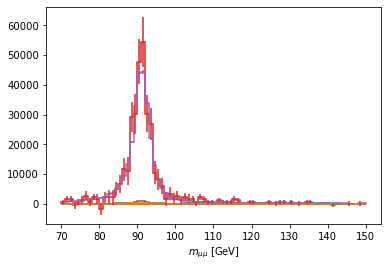

In [6]:
a=hists['mass']
b = a.to_hist().plot()

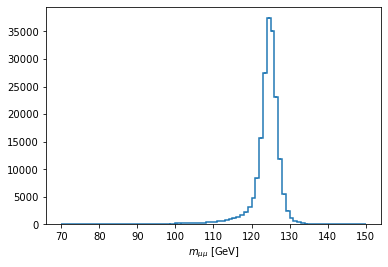

In [35]:
a=results['mass']
b = a.to_hist().plot()

In [25]:
results['ntot']

defaultdict_accumulator(int, {'vbf': 650799})

In [66]:
# muons
muons = events.Muon
sel_mu_1 = (muons.mediumId) & (muons.pt > 15)  & (abs(muons.eta) < 2.4)
sel_mu_2 = (abs(muons.dxy) < 0.2) & (abs(muons.dz) < 0.5)
sel_mu_3 = (muons.pfIsoId >= 2) # loose relPFIso

good_muon_mask = (sel_mu_1) & (sel_mu_2) & (sel_mu_3) 
# Rochester correction

# Dress the muons by FSR Photons
sel_good_muon = (ak.sum(good_muon_mask,axis=1) > 1)
muons = muons.mask[sel_good_muon]
good_muons = muons[good_muon_mask]
events = events.mask[sel_good_muon]



In [67]:
# https://gitlab.cern.ch/akhukhun/roccor
# https://github.com/CoffeaTeam/coffea/blob/master/coffea/lookup_tools/rochester_lookup.py
# https://github.com/TopEFT/topcoffea/blob/master/topcoffea/modules/corrections.py#L359
def apply_rochester_correction(mu, is_mc=True, year='2018'):
    if year=='2016': rochester_data = lookup_tools.txt_converters.convert_rochester_file("data/MuonScale/RoccoR2016.txt", loaduncs=True)
    elif year=='2017': rochester_data = lookup_tools.txt_converters.convert_rochester_file("data/MuonScale/RoccoR2017.txt", loaduncs=True)
    elif year=='2018': rochester_data = lookup_tools.txt_converters.convert_rochester_file("/data/pubfs/xiaoj/test/roc/RoccoR/RoccoR2018.txt", loaduncs=True)
    rochester = lookup_tools.rochester_lookup.rochester_lookup(rochester_data)
    if is_mc:
        hasgen = ~np.isnan(ak.fill_none(mu.matched_gen.pt, np.nan))
        mc_rand = np.random.rand(*ak.to_numpy(ak.flatten(mu.pt)).shape)
        mc_rand = ak.unflatten(mc_rand, ak.num(mu.pt, axis=1))
        corrections = np.array(ak.flatten(ak.ones_like(mu.pt)))
        errors = np.array(ak.flatten(ak.ones_like(mu.pt)))
        
        mc_kspread = rochester.kSpreadMC(mu.charge[hasgen],mu.pt[hasgen],mu.eta[hasgen],mu.phi[hasgen],mu.matched_gen.pt[hasgen])
        mc_ksmear = rochester.kSmearMC(mu.charge[~hasgen],mu.pt[~hasgen],mu.eta[~hasgen],mu.phi[~hasgen],mu.nTrackerLayers[~hasgen],mc_rand[~hasgen])
        errspread = rochester.kSpreadMCerror(mu.charge[hasgen],mu.pt[hasgen],mu.eta[hasgen],mu.phi[hasgen],mu.matched_gen.pt[hasgen])
        errsmear = rochester.kSmearMCerror(mu.charge[~hasgen],mu.pt[~hasgen],mu.eta[~hasgen],mu.phi[~hasgen],mu.nTrackerLayers[~hasgen],mc_rand[~hasgen])
        hasgen_flat = np.array(ak.flatten(hasgen))
        corrections[hasgen_flat] = np.array(ak.flatten(mc_kspread))
        corrections[~hasgen_flat] = np.array(ak.flatten(mc_ksmear))
        errors[hasgen_flat] = np.array(ak.flatten(errspread))
        errors[~hasgen_flat] = np.array(ak.flatten(errsmear))
        corrections = ak.unflatten(corrections, ak.num(mu.pt, axis=1))
        errors = ak.unflatten(errors, ak.num(mu.pt, axis=1))
    else:
        corrections = rochester.kScaleDT(mu.charge, mu.pt, mu.eta, mu.phi)
        errors = rochester.kScaleDTerror(mu.charge, mu.pt, mu.eta, mu.phi)
    
    pt_nom = mu.pt * corrections
    pt_err = mu.pt * errors
    # tmp = np.array(ak.flatten(pt_nom + pt_err))
    # tmp[tmp < 0] = 0
    # pt_up = ak.unflatten(tmp, ak.num(pt_nom, axis=1))
    # tmp = np.array(ak.flatten(pt_nom - pt_err))
    # tmp[tmp < 0] = 0
    # pt_down = ak.unflatten(tmp, ak.num(pt_nom, axis=1))
    return pt_nom, pt_nom + pt_err, pt_nom - pt_err

In [68]:
good_muons['newpt'] , good_muons['newpt_up'] , good_muons['newpt_down'] = apply_rochester_correction(good_muons)

In [69]:
# final_mask = ak.fill_none(events.run!=None, False)
# good_muons=good_muons[final_mask]
# events = events[final_mask]


In [70]:
# with up.recreate("new_test.root", compression=None) as fout:
#     fout['Events'] = {
#         'Muon': good_muons,
#     }

# hah = up.lazy("new_test.root:Events")
# events = NanoEventsFactory.from_root("new_test.root", schemaclass=BaseSchema).events()

In [71]:
eles = events.Electron
# electrons
good_ele_mask = (eles.pt > 20) & (abs(eles.eta + eles.deltaEtaSC) < 2.5) & (eles.mvaFall17V2Iso_WP90)

sel_no_ele = (ak.sum(good_ele_mask,axis=1) < 1)

events = events.mask[sel_no_ele]

In [72]:
def is_clean(obj_A, obj_B, drmin=0.4):
   ## Method 1
   # pair_obj = ak.cartesian([obj_A, obj_B],nested=True)
   # obj1, obj2 = ak.unzip(pair_obj)
   # dr_jm = obj1.delta_r(obj2)
   # min_dr_jm = ak.min(dr_jm,axis=2)
   # mask = min_dr_jm > drmin
   
   ## Method 2
   objB_near, objB_dr = obj_A.nearest(obj_B, return_metric=True)
   mask = ak.fill_none(objB_dr > drmin, True) # I guess to use True is because if there are no objB, all the objA are clean
   return (mask)


In [73]:
# jets
jets = events.Jet
# jet cleaned w.r.t. muons
clean_jet_mask = is_clean(jets, good_muons, 0.4)
# clean jets
sel_clean_jet = (ak.sum(clean_jet_mask,axis=1) > 0)
jets = jets.mask[sel_clean_jet]
clean_jets = jets[clean_jet_mask]
events = events.mask[sel_clean_jet]
# sel_cleanj_1 = (clean_jets.pt > 25) & (abs(clean_jets.eta) < 4.7) & (clean_jets.isTight)

# bjets 
# sel_bjet = (sel_jet) & 

In [74]:
total_sel = ak.fill_none(events.run!=None, False)
events = events[total_sel]
good_muons = good_muons[total_sel]
clean_jets = clean_jets[total_sel]


In [36]:
trigger = {}
for idx, ihlt in enumerate(['IsoMu24']):
    trigger[ihlt] = events.HLT[ihlt]
jet_dict = {}
for ibr in clean_jets.fields:
    # cross indexing should be romoved, e.g., muonIdxG
    if (not 'Idx' in ibr) and (not ibr.endswith('G')):
        jet_dict[ibr] = clean_jets[ibr]

In [15]:
with up.recreate("new_test.root", compression=None) as fout:
    fout['Events'] = {
        'Jet': jet_dict,
        'basic': {
            'run':events.run,
            'luminosityBlock': events.luminosityBlock,
            'event': events.event,
        },
        'Muon': good_muons,
        'MET': events.MET,
        'PuppiMET': events.PuppiMET,
        'HLT': trigger,
    }

In [75]:
new_eve = {}
# muon info
new_eve['nMuon'] = ak.count(good_muons.pt,axis=-1)
for ibr in good_muons.fields:
    new_eve[f'Muon_{ibr}'] = good_muons[ibr]
# jet info
new_eve['nJet'] = ak.count(clean_jets.pt,axis=-1)
for ibr in clean_jets.fields:
    if not ibr in ['muonIdxG','electronIdxG']:
        new_eve[f'Jet_{ibr}'] = clean_jets[ibr]
ak.to_parquet(new_eve,"test1.parquet")

In [76]:
new_eve = {}
# muon info
new_eve['nMuon'] = ak.count(good_muons.pt,axis=-1)
for ibr in good_muons.fields:
    new_eve[f'Muon_{ibr}'] = good_muons[ibr]
# jet info
new_eve['nJet'] = ak.count(clean_jets.pt,axis=-1)
for ibr in clean_jets.fields:
    if not ibr in ['muonIdxG','electronIdxG']:
        new_eve[f'Jet_{ibr}'] = clean_jets[ibr]

eve_ak = ak.Array(new_eve)
ak.to_parquet(eve_ak,"test2.parquet")

In [77]:
a = ak.Array(
    {
        'Muon': good_muons,
        'Jet': clean_jets,
    }
)
ak.to_parquet(a,"test3.parquet")

In [2]:
# events = NanoEventsFactory.from_parquet("test3.parquet", schemaclass=BaseSchema)
from coffea import processor

class bare_sel(processor.ProcessorABC):
    """
    Object selection
    """

    def __init__(self):
        self._accumulator = processor.dict_accumulator(
            {
                "ntot": processor.defaultdict_accumulator(int),
                "npos": processor.defaultdict_accumulator(int),
                "nneg": processor.defaultdict_accumulator(int),
            }
        )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        result = self.accumulator.identity()
        print(events.fields)
        
        dataset = events.metadata['dataset']
        ntot = len(events)
        result["ntot"][dataset] += ntot
        return result

    def postprocess(self, accumulator):
        return accumulator


In [4]:
executor = processor.FuturesExecutor()

In [13]:
events = ak.from_parquet("/data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/GluGluHToMuMu_M125/GluGluHToMuMu_M125_14VnDlvjKT3.parquet")

In [15]:
events.HLT_IsoMu24[:5].to_list()

[True, True, True, True, True]

In [28]:
muon_dict = {}
for ibr in events.fields:
    if ibr.startswith('Muon_'):
        muon_dict[ibr.lstrip("Muon_")] = events[ibr]
muons = ak.zip(muon_dict, with_name="PtEtaPhiMCandidate")

In [16]:
events = events.mask[events.HLT_IsoMu24]

In [23]:
muons = ak.zip({
    'pt': events.Muon_pt,
    'eta': events.Muon_eta,
    'phi': events.Muon_phi,
    'mass': events.Muon_mass,
    'charge': events.Muon_charge,
}
    , with_name="PtEtaPhiMCandidate")

In [29]:
(muons[:,0]+muons[:,1]).eta[:5].to_list()

[2.341838836669922,
 0.2310517430305481,
 1.2362124919891357,
 2.3744890689849854,
 -1.093367338180542]

In [25]:
(muons[:,0]+muons[:,1]).eta[:5].to_list()

[2.341838836669922,
 0.2310517430305481,
 1.2362124919891357,
 2.3744890689849854,
 -1.093367338180542]

In [31]:
# muons.fields

In [20]:
jet_dict = {}
for ibr in events.fields:
    if ibr.startswith('Jet_'):
        jet_dict[ibr.lstrip("Jet_")] = events[ibr]
jets = ak.zip(jet_dict, with_name="PtEtaPhiMCandidate")
jets.eta[:5].to_list()


In [37]:
medium_bjet = jets.btagDeepFlavB > 0.2770
sel_n_medium_bjet = ak.sum(medium_bjet,axis=1)

In [43]:
medium_bjet.to_list()

[[False],
 [False],
 [False, False, False, False],
 [False],
 [False],
 [False],
 [False, False],
 [False],
 [False],
 [False, False, False],
 [False],
 [False, False],
 [False],
 [False, False],
 [False, False, False, False],
 [False, False],
 [False, False],
 [False],
 [False],
 [False, False, False],
 [False, False],
 [False, False, False],
 [False],
 [False, False],
 [False],
 [False],
 [False],
 [False],
 [False, False],
 [False],
 [False, False],
 [False, False, False, False],
 [False],
 [False, False],
 [False, False],
 [True, False],
 [False],
 [False],
 [False],
 [False, False, False],
 [False, False],
 [False],
 [False],
 [False],
 [False, False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False],
 [False, False],
 [False, False],
 [False, False],
 [True],
 [False, False],
 [False, False],
 [False],
 [False],
 [False],
 [False],
 [False, False, False],
 [False],
 [False],
 [False],
 [False, False, False, True],
 [False, False, True],
 [F

In [44]:
sel_n_medium_bjet[30:36].to_list()

[0, 0, 0, 0, 0, 1]

In [40]:
### JES JER
def apply_jet_corrections(year, corr_type="jet"):
    extract = extractor()
    extract.add_weight_sets(
        [
            f"* * {abs_path('jes/2018/Autumn18_V19_MC_L1FastJet_AK4PFchs.jec.txt')}",
            f"* * {abs_path('jes/2018/Autumn18_V19_MC_L2Relative_AK4PFchs.jec.txt')}",
            f"* * {abs_path('jes/2018/Autumn18_V19_MC_L3Absolute_AK4PFchs.jec.txt')}",
            f"* * {abs_path('jes/2018/Autumn18_V19_MC_L2L3Residual_AK4PFchs.jec.txt')}",
            f"* * {abs_path('jes/2018/Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs.junc.txt')}",
            f"* * {abs_path('jer/2018/Autumn18_V7b_MC_PtResolution_AK4PFchs.jr.txt')}",
            f"* * {abs_path('jer/2018/Autumn18_V7b_MC_SF_AK4PFchs.jersf.txt')}",
        ]
    )

    extract.finalize()
    evaluator = extract.make_evaluator()

    jec_names = dir(evaluator)
    print(jec_names)
    jec_inputs = {name: evaluator[name] for name in jec_names}
    jec_stack = JECStack(jec_inputs)
    name_map = jec_stack.blank_name_map
    name_map['JetPt'] = 'pt'
    name_map['JetMass'] = 'mass'
    name_map['JetEta'] = 'eta'
    name_map['JetPhi'] = 'phi'
    name_map['JetA'] = 'area'
    name_map['ptGenJet'] = 'pt_gen'
    name_map['ptRaw'] = 'pt_raw'
    name_map['massRaw'] = 'mass_raw'
    name_map['Rho'] = 'rho'
    name_map['METpt'] = 'pt'
    name_map['METphi'] = 'phi'
    name_map['UnClusteredEnergyDeltaX'] = 'MetUnclustEnUpDeltaX'
    name_map['UnClusteredEnergyDeltaY'] = 'MetUnclustEnUpDeltaY'
    if corr_type=='met': return CorrectedMETFactory(name_map)
    return CorrectedJetsFactory(name_map, jec_stack)


In [41]:
good_jets = clean_jets

In [42]:
if not False:
    good_jets["pt_raw"] = (1 - good_jets.rawFactor)*good_jets.pt
    good_jets["mass_raw"] = (1 - good_jets.rawFactor)*good_jets.mass
    good_jets["pt_gen"] =ak.values_astype(ak.fill_none(good_jets.matched_gen.pt, 0), np.float32)
    good_jets["rho"] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, good_jets.pt)[0]
    events_cache = events.caches[0]
    corrected_jets = apply_jet_corrections('2018', corr_type='jets').build(good_jets, lazy_cache=events_cache)
    jesr_unc = [i for i in corrected_jets.fields if i.startswith("JES") or i.startswith("JER")]
    good_jets["pt"] = corrected_jets.pt
    good_jets["mass"] = corrected_jets.mass
    for ibr in jesr_unc:
        good_jets[f"pt_{ibr}_up"] = corrected_jets[ibr].up.pt
        good_jets[f"pt_{ibr}_down"] = corrected_jets[ibr].down.pt
        good_jets[f"mass_{ibr}_up"] = corrected_jets[ibr].up.mass
        good_jets[f"mass_{ibr}_down"] = corrected_jets[ibr].down.mass
    # ordered by new pt: high -> low
    index = ak.argsort(good_jets.pt, ascending=False)
    good_jets = good_jets[index]


/home/pku/xiaoj/miniconda3/envs/xcu/lib/python3.9/site-packages/coffea/lookup_tools/txt_converters.py:288: UserWarning: JERSF file is in the new format with split-out systematic, only parsing totals!!!
  warnings.warn(


['Autumn18_V19_MC_L1FastJet_AK4PFchs', 'Autumn18_V19_MC_L2L3Residual_AK4PFchs', 'Autumn18_V19_MC_L2Relative_AK4PFchs', 'Autumn18_V19_MC_L3Absolute_AK4PFchs', 'Autumn18_V7b_MC_PtResolution_AK4PFchs', 'Autumn18_V7b_MC_SF_AK4PFchs', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_Absolute', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_Absolute_2018', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_BBEC1', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_BBEC1_2018', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_EC2', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_EC2_2018', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_FlavorQCD', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_HF', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_HF_2018', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_RelativeBal', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_RelativeSample_2018', 'Regrouped_Autumn18_V19_MC_Uncertaint

In [48]:
def corrected_polar_met(met_pt, met_phi, obj_pt, obj_phi, obj_pt_orig, deltas=None):
    sj, cj = np.sin(obj_phi), np.cos(obj_phi)
    x = met_pt * np.cos(met_phi) + ak.sum(
        obj_pt * cj - obj_pt_orig * cj, axis=1
    )
    y = met_pt * np.sin(met_phi) + ak.sum(
        obj_pt * sj - obj_pt_orig * sj, axis=1
    )
    if deltas:
        positive, dx, dy = deltas
        x = x + dx if positive else x - dx
        y = y + dy if positive else y - dy
    
    # return ak.zip({"pt": np.hypot(x, y), "phi": np.arctan2(y, x)})
    return np.hypot(x, y), np.arctan2(y, x)


In [49]:
MET['pt_roccorr'], MET['phi_roccorr'] = corrected_polar_met(MET.pt,MET.phi,good_muons.newpt,good_muons.phi,good_muons.phi)

# the jer is applied after considering roccorr on Muon
MET['pt'], MET['phi'] = corrected_polar_met(MET['pt_roccorr'],MET['phi_roccorr'],good_jets["pt"],good_jets["phi"],good_jets["pt_raw"])
MET['pt_UnclusteredEnergy_up'], MET['phi_UnclusteredEnergy_up'] = corrected_polar_met(
    MET['pt_roccorr'],
    MET['phi_roccorr'],
    good_jets["pt"],
    good_jets["phi"],
    good_jets["pt_raw"],
    (
        True,
        MET.MetUnclustEnUpDeltaX,
        MET.MetUnclustEnUpDeltaY,
    ),
)
MET['pt_UnclusteredEnergy_down'], MET['phi_UnclusteredEnergy_down'] = corrected_polar_met(
    MET['pt_roccorr'],
    MET['phi_roccorr'],
    good_jets["pt"],
    good_jets["phi"],
    good_jets["pt_raw"],
    (
        False,
        MET.MetUnclustEnUpDeltaX,
        MET.MetUnclustEnUpDeltaY,
    ),
)
for ibr in jesr_unc:
    MET[f"pt_{ibr}_up"], MET[f"phi_{ibr}_up"] = corrected_polar_met(MET['pt'],MET['phi'],good_jets[f"pt_{ibr}_up"],good_jets["phi"],good_jets["pt_raw"])
    MET[f"pt_{ibr}_down"], MET[f"phi_{ibr}_down"] = corrected_polar_met(MET['pt'],MET['phi'],good_jets[f"pt_{ibr}_down"],good_jets["phi"],good_jets["pt_raw"])


In [52]:
with up.recreate("new_test.root", compression=None) as fout:
    fout['Events'] = {
        'MET': MET,
    }

In [59]:
print(len(MET.pt))
MET.pt.layout.form

29531


{
    "class": "IndexedOptionArray64",
    "index": "i64",
    "content": "float32"
}

In [60]:
np.array(ak.to_list(MET.pt),dtype=np.int32)

array([ 37,  94, 110, ..., 116, 149, 251], dtype=int32)

In [63]:
MET.pt.to_numpy().data

array([ 37.932514,  94.55633 , 110.74531 , ..., 116.96571 , 149.32442 ,
       251.36964 ], dtype=float32)

In [40]:
good_muons.pt[0:5].to_list()

[[64.12452697753906, 23.723495483398438],
 [77.15625, 30.405256271362305],
 None,
 [141.04873657226562, 23.364160537719727],
 None]

In [41]:
good_muons.newpt[0:5].to_list()

[[64.13423919677734, 23.719892501831055],
 [77.39348602294922, 30.450531005859375],
 None,
 [141.38211059570312, 23.37615394592285],
 None]

In [23]:
MET.phi.layout.form

{
    "class": "IndexedOptionArray64",
    "index": "i64",
    "content": {
        "class": "VirtualArray",
        "form": {
            "class": "IndexedArray64",
            "index": "i64",
            "content": {
                "class": "VirtualArray",
                "form": {
                    "class": "NumpyArray",
                    "itemsize": 4,
                    "format": "f",
                    "primitive": "float32",
                    "parameters": {
                        "__doc__": "phi"
                    },
                    "form_key": "MET_phi%2C%21load"
                },
                "has_length": true
            }
        },
        "has_length": true,
        "parameters": {
            "__doc__": "phi"
        }
    }
}

In [45]:
MET.pt_orig.layout.form

AttributeError: no field named 'pt_orig'

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/awkward/highlevel.py#L1131)

In [72]:
is_data = False
met = events.MET

if not is_data:
    clean_jets["pt_raw"] = (1 - clean_jets.rawFactor)*clean_jets.pt
    clean_jets["mass_raw"] = (1 - clean_jets.rawFactor)*clean_jets.mass
    clean_jets["pt_gen"] =ak.values_astype(ak.fill_none(clean_jets.matched_gen.pt, 0), np.float32)
    clean_jets["rho"] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, clean_jets.pt)[0]
    events_cache = events.caches[0]
    new_clean_jets = apply_jet_corrections(2018, corr_type='jets').build(clean_jets, lazy_cache=events_cache)
    # new_met = apply_jet_corrections(2018, corr_type='met').build(met, new_clean_jets, lazy_cache=events_cache)
    # # SYSTEMATICS
    # cleanedJets=ApplyJetSystematics(cleanedJets,syst_var)
    # met=ApplyJetCorrections(year, corr_type='met').build(met_raw, cleanedJets, lazy_cache=events_cache)
    
    # clean_jets['JER_up'] = new_clean_jets.JER.up

['Autumn18_V19_MC_L1FastJet_AK4PFchs', 'Autumn18_V19_MC_L2L3Residual_AK4PFchs', 'Autumn18_V19_MC_L2Relative_AK4PFchs', 'Autumn18_V19_MC_L3Absolute_AK4PFchs', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_Absolute', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_Absolute_2018', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_BBEC1', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_BBEC1_2018', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_EC2', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_EC2_2018', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_FlavorQCD', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_HF', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_HF_2018', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_RelativeBal', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_RelativeSample_2018', 'Regrouped_Autumn18_V19_MC_UncertaintySources_AK4PFchs_Total', 'Summer19UL18_JRV2_MC_PtResolution_AK4PFchs', 

In [63]:
events.HLT.IsoMu24

[None, None, [70.88551330566406, 33.272789001464844]]

In [64]:
clean_jets[134:137].pt.to_list()

[None, None, [69.25, 32.9375]]

In [9]:
import os
os.system("ls /data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/DYJetsToLL_M-50")

DYJetsToLL_M-50_6MqpOcfdyIe.parquet
DYJetsToLL_M-50_70glydpsBW2.parquet
DYJetsToLL_M-50_8tFJCZv2l50.parquet
DYJetsToLL_M-50_DILzGaKBYyE.parquet
DYJetsToLL_M-50_f1sgDC6OZmR.parquet
DYJetsToLL_M-50_k4T9R5cngjp.parquet
DYJetsToLL_M-50_NZ5dIr71A9p.parquet
DYJetsToLL_M-50_Ptu93J7YxCe.parquet
DYJetsToLL_M-50_T6uYXnzSbyE.parquet
DYJetsToLL_M-50_ubM0QvfyLwA.parquet
DYJetsToLL_M-50_xei0UmCb9Xk.parquet


0

In [10]:
input_dict={
    'DYJetsToLL_M-50': [
        '/data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/DYJetsToLL_M-50/DYJetsToLL_M-50_6MqpOcfdyIe.parquet',
        '/data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/DYJetsToLL_M-50/DYJetsToLL_M-50_70glydpsBW2.parquet',
        '/data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/DYJetsToLL_M-50/DYJetsToLL_M-50_8tFJCZv2l50.parquet',
        '/data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/DYJetsToLL_M-50/DYJetsToLL_M-50_DILzGaKBYyE.parquet',
        '/data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/DYJetsToLL_M-50/DYJetsToLL_M-50_f1sgDC6OZmR.parquet',
        '/data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/DYJetsToLL_M-50/DYJetsToLL_M-50_T6uYXnzSbyE.parquet',
        '/data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/DYJetsToLL_M-50/DYJetsToLL_M-50_xei0UmCb9Xk.parquet',        
    ],
}

In [11]:
results = processor.run_parquet_job(
    input_dict,
    'Events',
    processor_instance=bare_sel(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 100},
    # chunksize=int(cfg['chunksize']),
    maxchunks=None,
)


Processing:   0%|          | 0/7 [00:00<?, ?chunk/s]

/home/pku/xiaoj/miniconda3/envs/xcu/lib/python3.9/site-packages/coffea/processor/executor.py:261: UserWarning: Cancelling 5 running jobs (likely due to an exception)
  warnings.warn(


NameError: name 'events' is not defined

Failed processing file: WorkItem(dataset='DYJetsToLL_M-50', filename='/data/pubfs/xiaoj/hmm/ntuple/nanov7/obj_sel/DYJetsToLL_M-50/DYJetsToLL_M-50_6MqpOcfdyIe.parquet', treename='Events', entrystart=0, entrystop=0, fileuuid='', usermeta=None)

In [7]:
results['ntot']

defaultdict_accumulator(int, {'DYJetsToLL_M-50': 43505})

In [56]:
eve.Jet_area[0:5].to_list()

[[0.54833984375, 0.428955078125],
 [0.5185546875, 0.54833984375, 0.478759765625, 0.52880859375, 0.5185546875],
 [0.46875,
  0.5185546875,
  0.44873046875,
  0.458740234375,
  0.498779296875,
  0.478759765625],
 [0.53857421875, 0.5185546875, 0.52880859375],
 [0.5087890625]]

## Don't remove, the place to make the "clean" with cartesian clear

In [ ]:
jtmp = jets[0:3]
mtmp = good_muons[0:3]

pair_obj = ak.cartesian([jtmp, mtmp],nested=True)
obj1, obj2 = ak.unzip(pair_obj)
obj1.delta_r(obj2)

<Array [[[0.0113], [4.6, ... 0.00839], [1.43]]] type='3 * var * var * float32'>

In [ ]:
obj1.delta_r(obj2).to_list()

[[[0.011299419216811657], [4.601864337921143]],
 [[0.005097805988043547, 3.1803181171417236],
  [3.207820415496826, 0.028553511947393417],
  [4.776998043060303, 3.171268939971924]],
 [[0.00838739424943924], [1.430845856666565]]]

In [ ]:
obj1.pt.to_list()

[[[57.96875], [19.421875]],
 [[47.28125, 47.28125], [35.3125, 35.3125], [28.03125, 28.03125]],
 [[35.96875], [15.609375]]]

In [ ]:
obj2.pt.to_list()

[[[53.41250228881836], [53.41250228881836]],
 [[42.005924224853516, 31.437562942504883],
  [42.005924224853516, 31.437562942504883],
  [42.005924224853516, 31.437562942504883]],
 [[32.56406784057617], [32.56406784057617]]]

In [ ]:
a = obj1.delta_r(obj2)
ak.min(a,axis=2).to_list()

[[0.011299419216811657, 4.601864337921143],
 [0.005097805988043547, 0.028553511947393417, 3.171268939971924],
 [0.00838739424943924, 1.430845856666565]]

In [ ]:
jtmp.pt.to_list()

[[57.96875, 19.421875], [47.28125, 35.3125, 28.03125], [35.96875, 15.609375]]

In [ ]:
mtmp.pt.to_list()

[[53.41250228881836],
 [42.005924224853516, 31.437562942504883],
 [32.56406784057617]]

In [ ]:
jtmp[:,0].delta_r(mtmp).to_list()

[[0.011299419216811657],
 [0.005097805988043547, 3.1803181171417236],
 [0.00838739424943924]]

In [ ]:
jtmp[:,1].delta_r(mtmp).to_list()

[[4.601864337921143],
 [3.207820415496826, 0.028553511947393417],
 [1.430845856666565]]

In [ ]:
jtmp[:,0].delta_r(mtmp[:,0]).to_list()

[0.011299419216811657, 0.005097805988043547, 0.00838739424943924]

In [ ]:
a = obj1.delta_r(obj2)
b = ak.min(a,axis=2)
c = (b > 0.4)
clean_jets = jtmp[c]
(clean_jets.pt).to_list()

[[19.421875], [28.03125], [15.609375]]